# 2.3 The Tidy and Data Cube Forms

In the previous section, we saw how to repeat an analysis for every slice of a variable, by splitting the `DataFrame` on that variable using `.groupby()`:

**Documentation**

* pandas.DataFrame.reset_index(): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
* pandas.DataFrame.unstack(): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html
* pandas.DataFrame.stack(): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html

In [5]:
%matplotlib inline
import pandas as pd
df = pd.read_csv("../data/titanic.csv")

df.groupby("pclass").survived.sum()

pd.DataFrame([df.groupby("pclass").survived.sum(), df.groupby("pclass").survived.count()])

pclass      1    2    3
survived  200  119  181
survived  323  277  709

We can also repeat an analysis for every combination of values of multiple variables:

In [2]:
df.head()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

In [10]:
survival_counts = df.groupby(["pclass", "sex"]).survived.sum()

survival_counts, type(survival_counts)

(pclass  sex   
 1       female    139
         male       61
 2       female     94
         male       25
 3       female    106
         male       75
 Name: survived, dtype: int64,
 pandas.core.series.Series)

Note that this is a `Series` with a two-level index, not a `DataFrame` with three columns. If we wanted `pclass` and `sex` to instead be columns in a `DataFrame`, we could reset the index:

In [8]:
survival_counts.reset_index()

pclass     sex  survived
0       1  female       139
1       1    male        61
2       2  female        94
3       2    male        25
4       3  female       106
5       3    male        75

Either way, there is exactly one row per unique combination of `pclass` and `sex`. When each row represents a distinct combination of values of variables, it is said to be in **tidy form**. Many libraries expect data to be in this form, but tidy form is sometimes inconvenient to read. For example, in the above data frame, it is not easy to compare the number of females who survived across classes 1, 2, and 3.

## Data Cube Form

It would be more convenient if the data were arranged so that the values of `pclass` are along one dimension and the values of `sex` are along another. We can achieve this by **pivoting** the data. 

Generally speaking we want the following:

In [40]:
scounts = survival_counts.reset_index()

#[[int(scounts[(scounts.pclass ==p) & (scounts.sex == s)])  for s in scounts.sex.unique() ]for p in scounts.pclass.unique()]


tmp =[[int(scounts[(scounts["pclass"]== c) & (scounts["sex"]=="female")].survived),
       int(scounts[(scounts["pclass"]== c) & (scounts["sex"]=="male")].survived)] 
      for c in scounts.pclass.unique()]

scounts, pd.DataFrame(tmp, columns = ["female", "male"], index = scounts.pclass.unique())



#pd.DataFrame(tmp, index = scounts.pclass.unique(), columns=scounts.sex.unique())


(   pclass     sex  survived
 0       1  female       139
 1       1    male        61
 2       2  female        94
 3       2    male        25
 4       3  female       106
 5       3    male        75,
    female  male
 1     139    61
 2      94    25
 3     106    75)

In [28]:
tmp

[[139, 61], [94, 25], [106, 75]]

This is complex, and `pandas` recognizes the need to make this process simpler.

The easiest way to do this in `pandas` is using the `.unstack()` method, which turns the innermost level of the index into columns.

In [41]:
survival_counts

pclass  sex   
1       female    139
        male       61
2       female     94
        male       25
3       female    106
        male       75
Name: survived, dtype: int64

In [43]:
survival_counts_cube = survival_counts.unstack()
survival_counts_cube

sex     female  male
pclass              
1          139    61
2           94    25
3          106    75

In [59]:
df.groupby(["sex","embarked", "pclass"]).survived.sum().unstack().unstack()

pclass     1          2          3        
embarked   C  Q   S   C  Q   S   C   Q   S
sex                                       
female    69  2  66  11  2  81  22  33  51
male      28  0  33   5  0  20  15   7  53

When there is one variable along each dimension, as in the `DataFrame` above, the data is said to be in **data cube form**. Data cube form makes it easy to compare the levels of one variable, fixing the value of the other variable. For example, we can compare the number of female survivors across the three passenger classes by simply looking at the first column.

Data cube form also happens to play nicely with bar charts in `pandas`. When `.plot.bar()` is called on a `pandas` `DataFrame`, one set of bars will be created for each column. So when we call `.plot.bar()` on the above `DataFrame`, we will get one set of bars for females and another set of bars for males.

<AxesSubplot:xlabel='pclass'>

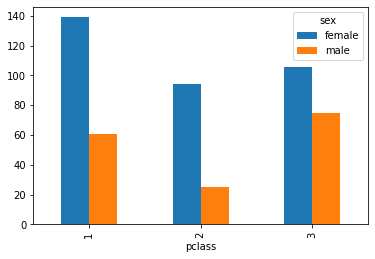

In [56]:
survival_counts_cube.plot.bar()

<AxesSubplot:xlabel='sex,embarked'>

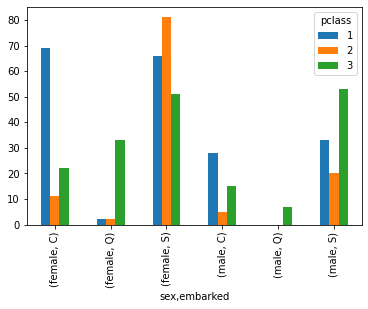

In [58]:
tmp1.plot.bar()

Notice that the $x$-axis is still the index of this `DataFrame`, which is `pclass`.

Although data cube form is convenient to read, it is not the canonical form the many libraries expect. However, given a `DataFrame` in data cube form, we can convert it to tidy form by using `.stack()` (which is the opposite of `.unstack()` above).

In [20]:
survival_counts_cube.stack()

pclass  sex   
1       female    139
        male       61
2       female     94
        male       25
3       female    106
        male       75
dtype: int64

## Roll-ups

In the above analysis, we calculated the number of survivors by `pclass` and `sex`. What if we wanted to use the results of this analysis to calculate the number of survivors by just `pclass`? To do this, we have to **roll-up** the variable `sex`.

The term _roll-up_ makes sense if the data is in data cube format. Right now, the data has two dimensions, `pclass` and `sex`. We want to reduce the data to just one dimension: `pclass`. To do this, we have to aggregate, or _roll-up_, the values over the `sex` dimension. We choose an aggregation function, like `.sum()` or `.mean()` or `.max()`. Although we have so far only applied these aggregation functions to `Series` (i.e., individual variables), they can also be applied to `DataFrame`s. When applied to a `DataFrame`, they take an additional keyword argument, `axis=`, that specifies the dimension to aggregate over.

- `axis=0` means aggregate _over_ the rows (i.e., dimension 0), returning one number per column
- `axis=1` means aggregate _over_ the columns (i.e., dimension 1), returning one number per row

In this case, we need to add up the number of male and female survivors, so we use the `.sum()` aggregation function.

In [64]:
survival_counts_cube

sex     female  male
pclass              
1          139    61
2           94    25
3          106    75

In [62]:
survival_counts_cube.sum(axis=0)  # sum across columns

sex
female    339
male      161
dtype: int64

In [65]:
survival_counts_cube.sum(axis=1) # sums across rows

pclass
1    200
2    119
3    181
dtype: int64

For comparison, here is the roll-up along the other axis:


In [22]:
survival_counts_cube.sum(axis=0)

sex
female    339
male      161
dtype: int64

Roll-ups can also be calculated when the data is in tidy form, although it is not as natural. We simply need to `.groupby()` the dimension(s) we want to keep and aggregate over the rest. However, 

`survival_counts.groupby("pclass").sum()`

won't work here. (Try it!) That's because `pclass` is not a column in `survival_counts`; it's in the index! To group by it, we either have to reset the index so that it *is* a column:

In [73]:
survival_counts.reset_index().groupby("pclass").survived.sum()


pclass
1    200
2    119
3    181
Name: survived, dtype: int64

In [66]:
survival_counts.reset_index().groupby("pclass").survived.sum()

pclass
1    200
2    119
3    181
Name: survived, dtype: int64

or specify to `.groupby()` to look for it in the index, using the `level=` keyword argument:

In [24]:
survival_counts.groupby(level="pclass").sum()

pclass
1    200
2    119
3    181
Name: survived, dtype: int64

# Exercises

Exercises 1-3 all deal with the Tips dataset (`../data/tips.csv`).

### **Exercise 1.** Calculate the average total bill by day, time, and table size. Show the `DataFrame` in data cube format. Because there are three variables, and a `DataFrame` is two-dimensional, you will need to have two variables along one dimension and one variable along the other.

Try different ways of arranging the data cube. For example, you could have:

- each row represent a day and time combination and each column represent a size.
- each row represent a day and each column represent a time and size combination.

In [ ]:
# TYPE YOUR CODE HERE.

**Exercise 2.** Using the data cube that you created in Exercise 1, roll-up the `size` variable by calculating the average total bill over the different table sizes. (_Hint:_ This can be easy or hard, depending on the data cube representation you chose in Exercise 1.)

Compare these results to the results you get when you calculate the average total bill by day and time from the original `DataFrame`. Why do they differ?

In [ ]:
# TYPE YOUR CODE HERE.

**Exercise 3.** Make a bar chart showing the average total bill by table size, day, and time. (You will have to decide which variable(s) to represent on the $x$-axis and which variable(s) to represent using different colored bars.)

In [ ]:
# TYPE YOUR CODE HERE.

**Submission Instructions**

Submit using the following command:

            handin dekhtyar 301-lab06

In [77]:

tmp2 = df[["pclass", "survived", "sex", "age"]]

tmp3 = tmp2.set_index(["pclass", "survived"])


In [86]:
tmp4 = tmp2.groupby(["pclass", "survived"]).count()

In [91]:
tmp4.unstack()

sex       age     
survived    0    1    0    1
pclass                      
1         123  200  103  181
2         158  119  146  115
3         528  181  370  131